In [1]:
import bioframe as bf
from gpn.data import load_table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/gwas/matched"

In [26]:
models = [
    "CADD.RawScore",
    #"phyloP",
    #"phastCons",
    "phyloP-Zoonomia",
    #"InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    #"LongSafari/hyenadna-large-1m-seqlen-hf",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    "Enformer.LogisticRegression",
    #"LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
]

#embedding_models = [
#    "Enformer",
#    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
#    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
#    "LongSafari/hyenadna-large-1m-seqlen-hf",
#    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
#]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,gene_id,tss_dist,match_group,CADD,phyloP-241-mammals,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,946538,G,A,0.001712,0.071586,False,ENSG00000187634,7263,205,-2.882880,-4.855,-0.782515,-0.682280,-0.374308,-0.745820,-0.711291
1,1,1224105,C,T,0.001093,0.096349,False,ENSG00000078808,4489,25,0.066271,0.101,-0.496645,-0.390871,-0.455918,-0.493835,-0.613754
2,1,1370532,C,T,0.005503,0.124852,False,ENSG00000175756,4623,71,0.051171,1.178,-0.349591,-0.512993,-0.411024,-0.273515,-0.414630
3,1,1428969,T,C,0.003939,0.220696,False,ENSG00000205116,3098,120,-0.065628,1.143,-0.329217,-0.593589,-0.465040,-0.337608,-0.499824
4,1,1797728,C,T,0.001670,0.004973,False,ENSG00000008130,17659,114,0.237202,0.249,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,22,50532837,T,C,1.000000,0.327615,True,ENSG00000177989,331,1537,-0.180658,0.487,-0.388536,-0.530901,-0.654694,-0.357289,-0.435950
4594,22,50583688,C,A,0.004348,0.355862,False,ENSG00000100288,839,1521,-0.558491,1.017,-0.463727,-0.236395,-0.641860,-0.380793,-0.421025
4595,22,50598496,C,G,0.001049,0.033284,False,ENSG00000008735,2295,1511,0.200327,0.188,-0.367395,-0.345762,-0.327461,-0.317739,-0.335759
4596,22,50706303,T,C,0.001094,0.284203,False,ENSG00000251322,807,1498,0.733525,1.602,-0.530251,-0.692740,-0.403717,-0.591968,-0.738031


In [27]:
"""
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()
""";

In [28]:
#V["Enformer_l2"] = -np.linalg.norm(V[features["Enformer"]], axis=1)
#models.append("Enformer_l2")

In [29]:
V.dropna(
    subset=models,# + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,gene_id,tss_dist,match_group,CADD,phyloP-241-mammals,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,946538,G,A,0.001712,0.071586,False,ENSG00000187634,7263,205,-2.882880,-4.855,-0.782515,-0.682280,-0.374308,-0.745820,-0.711291
1,1,1224105,C,T,0.001093,0.096349,False,ENSG00000078808,4489,25,0.066271,0.101,-0.496645,-0.390871,-0.455918,-0.493835,-0.613754
2,1,1370532,C,T,0.005503,0.124852,False,ENSG00000175756,4623,71,0.051171,1.178,-0.349591,-0.512993,-0.411024,-0.273515,-0.414630
3,1,1428969,T,C,0.003939,0.220696,False,ENSG00000205116,3098,120,-0.065628,1.143,-0.329217,-0.593589,-0.465040,-0.337608,-0.499824
5,1,1992242,A,G,0.001107,0.423779,False,ENSG00000142609,1313,44,-0.198083,0.181,-0.240716,-0.379446,-0.393912,-0.270286,-0.282701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,22,50532837,T,C,1.000000,0.327615,True,ENSG00000177989,331,1537,-0.180658,0.487,-0.388536,-0.530901,-0.654694,-0.357289,-0.435950
4594,22,50583688,C,A,0.004348,0.355862,False,ENSG00000100288,839,1521,-0.558491,1.017,-0.463727,-0.236395,-0.641860,-0.380793,-0.421025
4595,22,50598496,C,G,0.001049,0.033284,False,ENSG00000008735,2295,1511,0.200327,0.188,-0.367395,-0.345762,-0.327461,-0.317739,-0.335759
4596,22,50706303,T,C,0.001094,0.284203,False,ENSG00000251322,807,1498,0.733525,1.602,-0.530251,-0.692740,-0.403717,-0.591968,-0.738031


In [30]:
V = V[V.duplicated("match_group", keep=False)]
n_pos, n_neg = V.label.sum(), (~V.label).sum()
subtitle = f"n={n_pos} vs. {n_neg}"
V.label.value_counts()

label
False    1997
True     1997
Name: count, dtype: int64

In [31]:
"""
for m in embedding_models:
    print(m)
    model_name = f"{m} - full inner product"
    V[model_name] = V[features[m]].sum(axis=1)
    if model_name not in models: models.append(model_name)
""";

In [32]:
# request by yss
-V[V.pos==20381010][models].T

,3456
CADD,1.562906
phyloP-241-mammals,1.859000
multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,0.789847
InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,0.422776
Enformer.LogisticRegression,0.817433
multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,0.739073
multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,0.652139


In [33]:
results = []
for m in models:
    results.append([m, roc_auc_score(V.label, -V[m])])
results = pd.DataFrame(results, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

,Model,AUROC
2,multiz100way/89/128/64/True/defined.phastCons....,0.735880
5,multiz100way/89/256/128/True/defined.phastCons...,0.734104
6,multiz100way/89/512/256/True/defined.phastCons...,0.722680
4,Enformer.LogisticRegression,0.716379
3,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,0.677126
0,CADD,0.642284
1,phyloP-241-mammals,0.629989


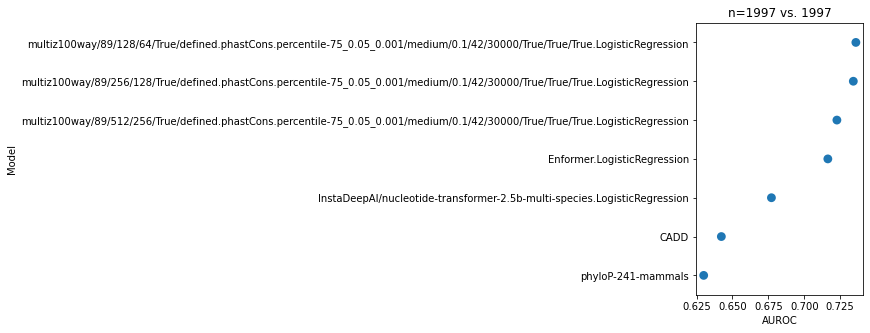

In [34]:
plt.figure(figsize=(3,5))
sns.pointplot(
    data=results,
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);